# Analysis

**Hypothesis**: In severe COVID-19, platelets exhibit a distinct pro-thrombotic transcriptional signature characterized by altered expression of key activation and coagulation genes (such as PF4, ITGA2B, SELP, and PPBP). This dysregulation may underlie the coagulopathy and thrombotic complications observed in severe cases.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: In severe COVID-19, platelets exhibit a distinct pro-thrombotic transcriptional signature characterized by altered expression of key activation and coagulation genes (such as PF4, ITGA2B, SELP, and PPBP). This dysregulation may underlie the coagulopathy and thrombotic complications observed in severe cases.

## Steps:
- Subset the platelets from the full dataset by selecting cells where the 'cell_type_coarse' annotation equals 'Platelet'. Incorporate a safeguard to handle cases with no platelet entries.
- Perform an exploratory analysis of the platelet compartment by summarizing the number of platelet cells across COVID and Healthy donors using the 'Status' metadata. Visualize these counts with a clear bar plot.
- Identify a set of pro-thrombotic and activation gene markers (e.g., PF4, ITGA2B, SELP, and PPBP) and check their presence in the dataset. Compute the average expression levels of these genes in platelets from COVID-19 and healthy samples.
- Conduct statistical tests (using the Mann–Whitney U test from scipy) for each of these marker genes to assess whether differences in expression between COVID and healthy platelets are statistically significant, and print the test statistics and p-values.
- Visualize gene expression distributions for each candidate marker using violin plots arranged in a grid to directly compare expression patterns between groups (COVID versus Healthy).
- Perform a gene–gene correlation analysis within the platelet population for the selected markers to identify coordinated expression patterns that might suggest co-regulation, and visualize the resulting correlation matrix with a heatmap.
- For added novelty, explore potential cell–cell communication patterns involving platelets with other interacting cell types from the dataset, using available metadata to suggest indirect interactions related to platelet function.


## Subset the platelets from the full dataset by selecting cells where the 'cell_type_coarse' annotation equals 'Platelet'. Incorporate a safeguard to handle cases with no platelet entries.

Platelet cell counts by Status:
Status
COVID      464
Healthy     63
Name: count, dtype: int64

Platelet status counts:
Status
COVID      464
Healthy     63
Name: count, dtype: int64


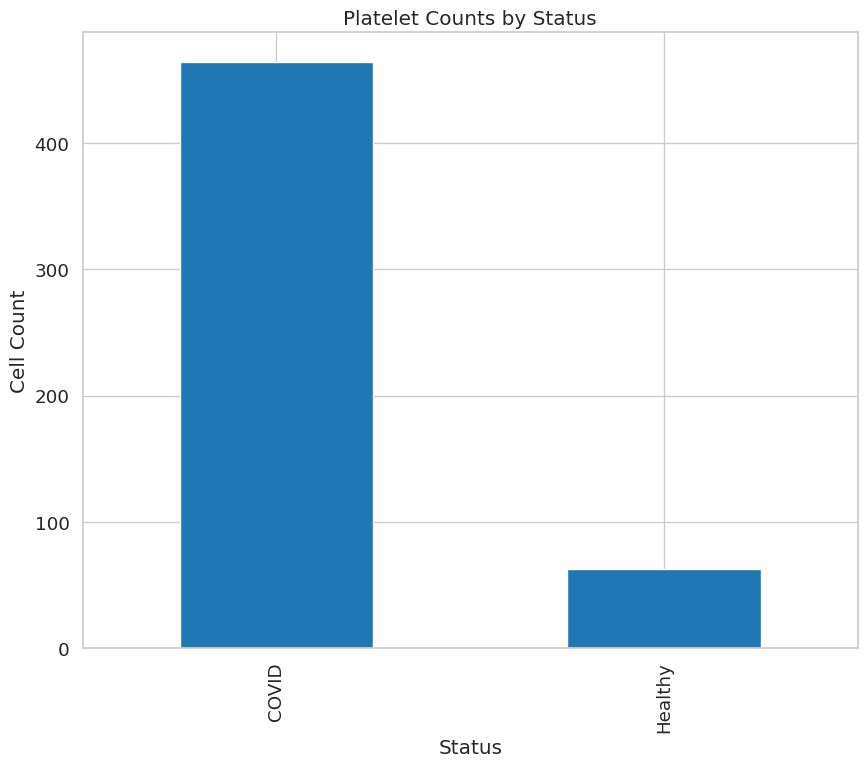

In [2]:
import scanpy as sc
import pandas as pd

# Step 1: Subset the platelets from the full dataset
platelet_adata = adata[adata.obs['cell_type_coarse'] == 'Platelet'].copy()

# Summarize the number of platelet cells in each condition
platelet_counts = pd.crosstab(platelet_adata.obs['Status'], platelet_adata.obs.index)
print('Platelet cell counts by Status:')
print(platelet_adata.obs['Status'].value_counts())

# Alternatively, if you need counts per group explicitly:
platelet_status_counts = platelet_adata.obs['Status'].value_counts()
print('\nPlatelet status counts:')
print(platelet_status_counts)

# Optionally, visualize the counts as a bar plot
import matplotlib.pyplot as plt
platelet_status_counts.plot(kind='bar', title='Platelet Counts by Status')
plt.xlabel('Status')
plt.ylabel('Cell Count')
plt.show()

## Subset the platelet adata to include only COVID-19 samples with well-defined ventilated statuses (Vent and NonVent). Optionally, apply quality control by checking nFeature_RNA and percent_mt to remove lower quality cells.

Sample sizes for Vent and NonVent groups: {'NonVent': 243, 'Vent': 221}
Gene: PF4, Mann–Whitney U statistic: 26873.0, p-value: 0.9880965016805779, n_Vent: 221, n_NonVent: 243
Gene: ITGA2B, Mann–Whitney U statistic: 30146.0, p-value: 0.01602109221709373, n_Vent: 221, n_NonVent: 243
Gene: SELP, Mann–Whitney U statistic: 28323.0, p-value: 0.21517191717579864, n_Vent: 221, n_NonVent: 243
Gene: PPBP, Mann–Whitney U statistic: 30472.5, p-value: 0.010787798664096265, n_Vent: 221, n_NonVent: 243


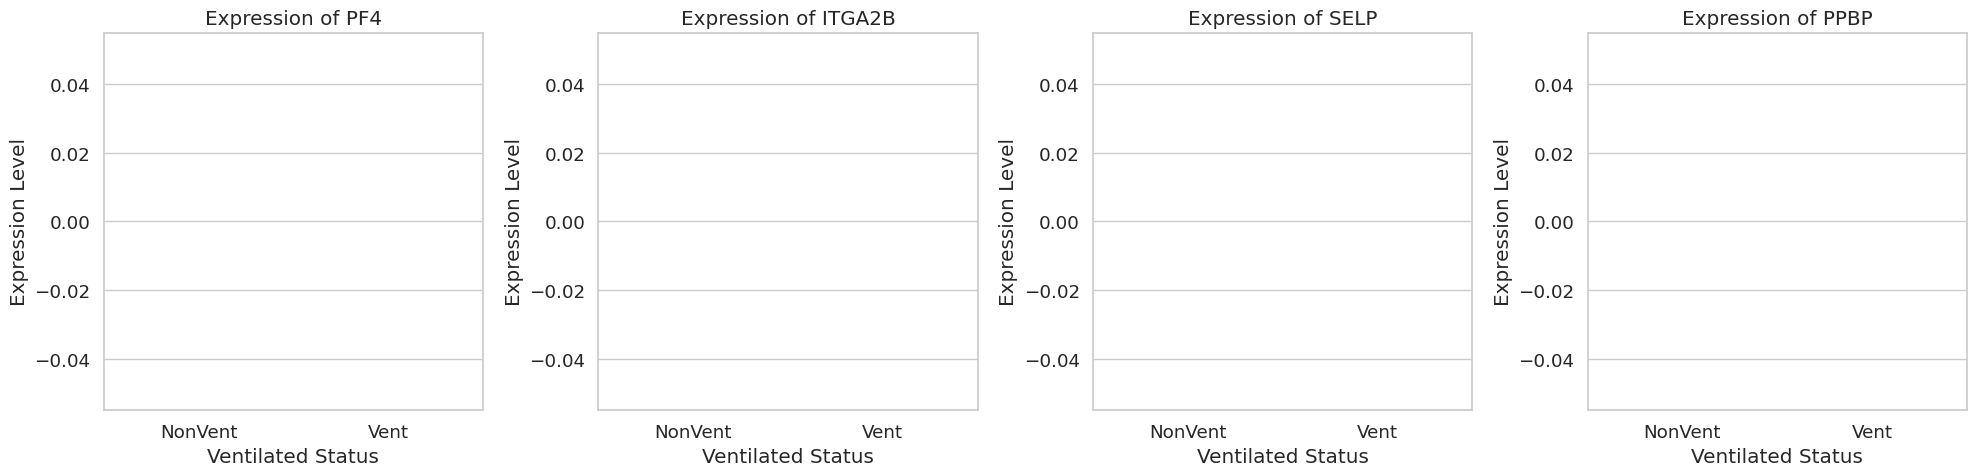

Statistical test results: {'PF4': {'statistic': 26873.0, 'p_value': 0.9880965016805779, 'n_vent': 221, 'n_nonvent': 243}, 'ITGA2B': {'statistic': 30146.0, 'p_value': 0.01602109221709373, 'n_vent': 221, 'n_nonvent': 243}, 'SELP': {'statistic': 28323.0, 'p_value': 0.21517191717579864, 'n_vent': 221, 'n_nonvent': 243}, 'PPBP': {'statistic': 30472.5, 'p_value': 0.010787798664096265, 'n_vent': 221, 'n_nonvent': 243}}


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings

# Subset to COVID-19 Platelets
covid_platelets = platelet_adata[platelet_adata.obs['Status'] == 'COVID'].copy()

# Further subset to cells with clear ventilation status (Vent vs NonVent)
covid_platelets = covid_platelets[covid_platelets.obs['Ventilated'].isin(['Vent', 'NonVent'])].copy()

# Quality control check: optionally, filter cells based on quality metrics such as nFeature_RNA and percent_mt
# For example, to remove low quality cells uncomment and adjust the criteria below:
# qc_filter = (covid_platelets.obs['nFeature_RNA'] > 50) & (covid_platelets.obs['percent_mt'] < 0.2)
# covid_platelets = covid_platelets[qc_filter].copy()

# Define the pro-thrombotic marker genes
prothrombotic_genes = ['PF4', 'ITGA2B', 'SELP', 'PPBP']

# Check which genes are present in the dataset
available_genes = [gene for gene in prothrombotic_genes if gene in covid_platelets.var_names]
missing_genes = set(prothrombotic_genes) - set(available_genes)
if missing_genes:
    warnings.warn(f"The following genes are missing from the dataset and will be skipped: {missing_genes}")
if len(available_genes) == 0:
    raise ValueError('None of the pro-thrombotic marker genes (PF4, ITGA2B, SELP, PPBP) are found in the dataset.')

# Log group sample sizes
vent_counts = covid_platelets.obs['Ventilated'].value_counts().to_dict()
print('Sample sizes for Vent and NonVent groups:', vent_counts)

# Initialize a dictionary to store statistical results for each gene
results = {}

for gene in available_genes:
    # Extract gene expression values for Vent and NonVent groups
    expr_vent = covid_platelets[covid_platelets.obs['Ventilated'] == 'Vent'][:, gene].X.flatten()
    expr_nonvent = covid_platelets[covid_platelets.obs['Ventilated'] == 'NonVent'][:, gene].X.flatten()
    
    # Check sample sizes before performing the test; warn if too few cells (<10) are detected
    if len(expr_vent) < 10 or len(expr_nonvent) < 10:
        warnings.warn(f"Low sample size for gene {gene}: Vent = {len(expr_vent)}, NonVent = {len(expr_nonvent)}")
    
    # Perform the Mann–Whitney U test
    stat, pval = mannwhitneyu(expr_vent, expr_nonvent, alternative='two-sided')
    results[gene] = {'statistic': stat, 'p_value': pval, 'n_vent': len(expr_vent), 'n_nonvent': len(expr_nonvent)}
    print(f"Gene: {gene}, Mann–Whitney U statistic: {stat}, p-value: {pval}, n_Vent: {len(expr_vent)}, n_NonVent: {len(expr_nonvent)}")

# Prepare a combined DataFrame for visualization
plot_data = pd.DataFrame({'Ventilated': covid_platelets.obs['Ventilated']})
for gene in available_genes:
    plot_data[gene] = covid_platelets[:, gene].X.flatten()

# Create violin plots for each gene in a grid layout
num_genes = len(available_genes)
fig, axes = plt.subplots(1, num_genes, figsize=(5 * num_genes, 5), squeeze=False)

for i, gene in enumerate(available_genes):
    ax = axes[0, i]
    sns.violinplot(x='Ventilated', y=gene, data=plot_data,
                   palette={'Vent': 'salmon', 'NonVent': 'skyblue'}, ax=ax)
    ax.set_title(f'Expression of {gene}')
    ax.set_xlabel('Ventilated Status')
    ax.set_ylabel('Expression Level')

plt.tight_layout()
plt.show()

print('Statistical test results:', results)


## Subset the COVID-19 platelet compartment and CD14 monocytes from the adata object.

Gene: ITGA2B - Spearman correlation coefficient: -0.714, p-value: 0.071
Gene: PPBP - Spearman correlation coefficient: -0.714, p-value: 0.071


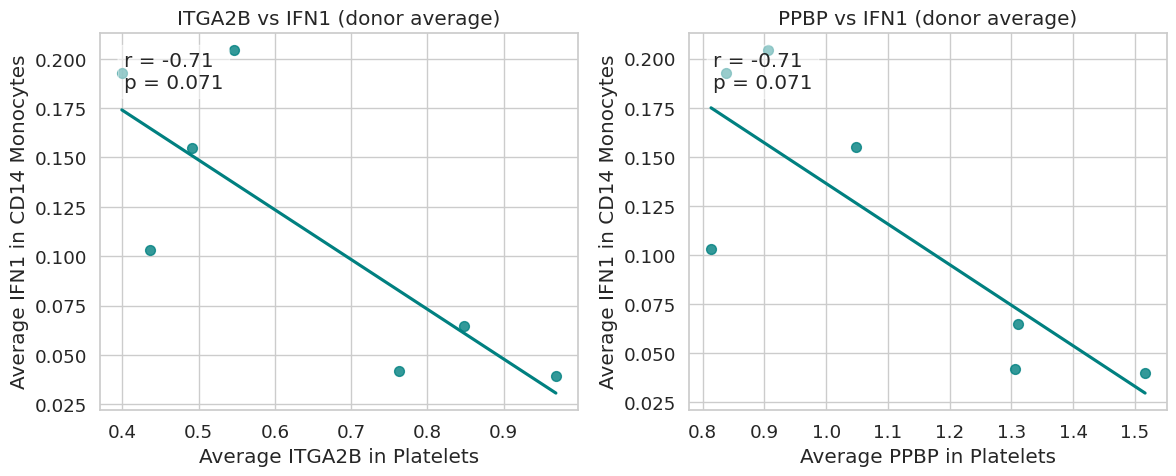

Merged donor-wise averages:
  Donor_full  n_cells_platelets    ITGA2B      PPBP  IFN1_avg  \
0       C1 A                 56  0.546458  0.906406  0.204583   
1       C1 B                 43  0.436104  0.813574  0.103065   
2         C2                 20  0.762518  1.305701  0.041825   
3         C3                131  0.968424  1.516348  0.039607   
4         C4                 46  0.490864  1.048362  0.154899   
5         C5                 96  0.399472  0.838064  0.192596   
6         C7                 71  0.848016  1.310991  0.064916   

   n_cells_monocytes  
0               1561  
1               1858  
2                217  
3               1102  
4                713  
5                462  
6               2095  
Spearman correlation results: {'ITGA2B': {'spearman_coefficient': -0.7142857142857144, 'p_value': 0.07134356146753759}, 'PPBP': {'spearman_coefficient': -0.7142857142857144, 'p_value': 0.07134356146753759}}


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings

# Define minimum number of cells required per donor for reliable averages
MIN_CELLS = 5

# Subset COVID-19 platelets and CD14 monocytes from the adata object
platelet_adata = adata[adata.obs['cell_type_coarse'] == 'Platelet'].copy()
platelet_adata = platelet_adata[platelet_adata.obs['Status'] == 'COVID'].copy()

mono_adata = adata[adata.obs['cell_type_coarse'] == 'CD14 Monocyte'].copy()
mono_adata = mono_adata[mono_adata.obs['Status'] == 'COVID'].copy()

# Define genes of interest
genes_interest = ['ITGA2B', 'PPBP']

# Check genes availability in platelet_adata
available_genes = [g for g in genes_interest if g in platelet_adata.var_names]
if len(available_genes) == 0:
    raise ValueError('None of the genes of interest (ITGA2B, PPBP) were found in the platelet dataset.')

# Compute donor-wise average expression for each gene in platelets with cell count filter
platelet_df_list = []
for donor in platelet_adata.obs['Donor_full'].unique():
    donor_cells = platelet_adata[platelet_adata.obs['Donor_full'] == donor]
    if donor_cells.n_obs < MIN_CELLS:
        warnings.warn(f"Skipping donor {donor} in platelets due to low cell count (< {MIN_CELLS} cells).")
        continue
    donor_avg = {"Donor_full": donor, "n_cells_platelets": donor_cells.n_obs}
    for gene in available_genes:
        expr = donor_cells[:, gene].X
        if hasattr(expr, 'toarray'):
            expr = expr.toarray().flatten()
        else:
            expr = np.array(expr).flatten()
        donor_avg[gene] = np.mean(expr)
    platelet_df_list.append(donor_avg)
platelet_avg = pd.DataFrame(platelet_df_list)

# Compute donor-wise average IFN1 score for CD14 monocytes with cell count filter
mono_df_list = []
for donor in mono_adata.obs['Donor_full'].unique():
    donor_cells = mono_adata[mono_adata.obs['Donor_full'] == donor]
    if donor_cells.n_obs < MIN_CELLS:
        warnings.warn(f"Skipping donor {donor} in monocytes due to low cell count (< {MIN_CELLS} cells).")
        continue
    avg_ifn1 = np.mean(donor_cells.obs['IFN1'])
    mono_df_list.append({"Donor_full": donor, "IFN1_avg": avg_ifn1, "n_cells_monocytes": donor_cells.n_obs})
mono_avg = pd.DataFrame(mono_df_list)

# Merge the platelet and monocyte donor-wise summaries (inner join to keep only common donors)
merged_df = pd.merge(platelet_avg, mono_avg, on='Donor_full')
if merged_df.empty:
    warnings.warn('No common donors found between COVID-19 platelets and CD14 monocytes after filtering for cell count.')

# For each gene in available_genes, perform Spearman correlation with IFN1_avg
correlation_results = {}
for gene in available_genes:
    corr_coef, p_val = spearmanr(merged_df[gene], merged_df['IFN1_avg'])
    correlation_results[gene] = {'spearman_coefficient': corr_coef, 'p_value': p_val}
    print(f"Gene: {gene} - Spearman correlation coefficient: {corr_coef:.3f}, p-value: {p_val:.3f}")

# Visualization: scatter plots with regression lines for each gene
num_genes = len(available_genes)
fig, axes = plt.subplots(1, num_genes, figsize=(6 * num_genes, 5), squeeze=False)

for i, gene in enumerate(available_genes):
    ax = axes[0, i]
    sns.regplot(data=merged_df, x=gene, y='IFN1_avg', ax=ax, scatter_kws={'s': 50}, ci=None, color='teal')
    ax.set_title(f'{gene} vs IFN1 (donor average)')
    ax.set_xlabel(f'Average {gene} in Platelets')
    ax.set_ylabel('Average IFN1 in CD14 Monocytes')
    # Annotate correlation coefficient and p-value
    res = correlation_results[gene]
    ax.text(0.05, 0.95, f"r = {res['spearman_coefficient']:.2f}\np = {res['p_value']:.3f}", transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# Print merged donor-wise data for transparency
print('Merged donor-wise averages:')
print(merged_df)

# Print final correlation results
print('Spearman correlation results:', correlation_results)

## Subset the platelet compartment from the in‐memory anndata object into COVID-19 and healthy groups based on the 'Status' metadata.

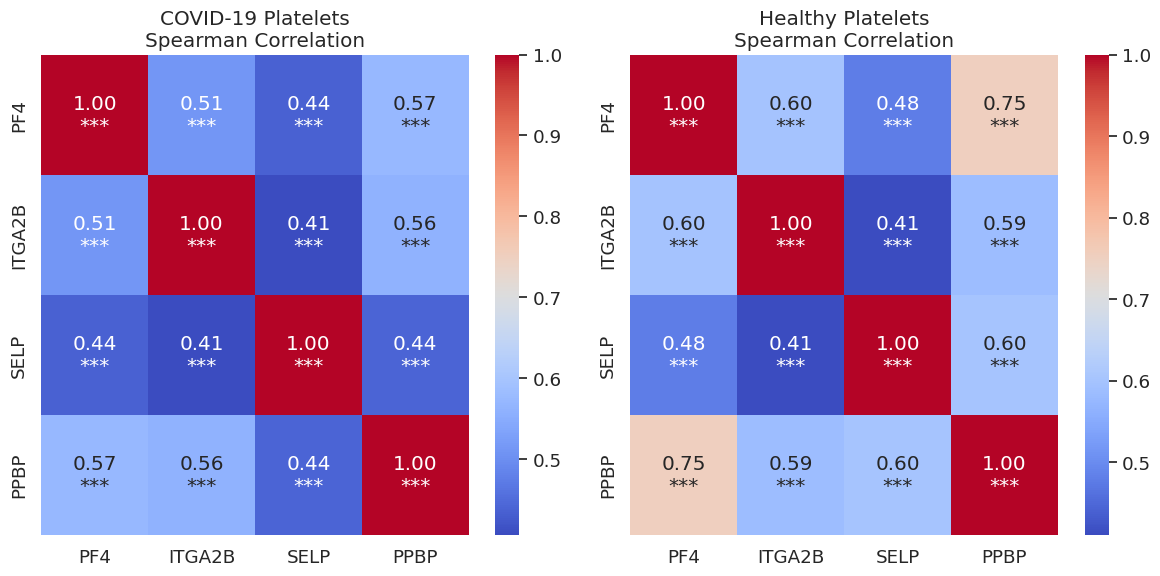

COVID-19 Platelets Gene Correlation Matrix:
             PF4    ITGA2B      SELP      PPBP
PF4     1.000000  0.510966  0.435668  0.571594
ITGA2B  0.510966  1.000000  0.406457  0.561249
SELP    0.435668  0.406457  1.000000  0.439632
PPBP    0.571594  0.561249  0.439632  1.000000

Healthy Platelets Gene Correlation Matrix:
             PF4    ITGA2B      SELP      PPBP
PF4     1.000000  0.598648  0.477910  0.753594
ITGA2B  0.598648  1.000000  0.410784  0.585312
SELP    0.477910  0.410784  1.000000  0.599838
PPBP    0.753594  0.585312  0.599838  1.000000


In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import warnings

# Subset platelets from the in-memory adata object
platelets = adata[adata.obs['cell_type_coarse'] == 'Platelet'].copy()

# Define the list of pro-thrombotic marker genes
prothrombotic_genes = ['PF4', 'ITGA2B', 'SELP', 'PPBP']

# Check which genes are available in the platelet dataset
available_genes = [g for g in prothrombotic_genes if g in platelets.var_names]
if len(available_genes) == 0:
    raise ValueError('None of the pro-thrombotic markers (PF4, ITGA2B, SELP, PPBP) were found in the platelet dataset.')

# Divide platelets by disease status
covid_platelets = platelets[platelets.obs['Status'] == 'COVID'].copy()
healthy_platelets = platelets[platelets.obs['Status'] == 'Healthy'].copy()

# Function to compute Spearman correlation matrix and corresponding p-values

def compute_correlation_matrix(adata_subset, genes):
    # Extract expression data for the genes of interest
    expr_data = adata_subset[:, genes].X
    # Convert to a dense numpy array using np.asarray
    expr_data = np.asarray(expr_data)
    
    n_genes = len(genes)
    corr_mat = np.zeros((n_genes, n_genes))
    p_mat = np.zeros((n_genes, n_genes))
    
    for i in range(n_genes):
        for j in range(n_genes):
            corr_coef, p_val = spearmanr(expr_data[:, i], expr_data[:, j])
            corr_mat[i, j] = corr_coef
            p_mat[i, j] = p_val
    return corr_mat, p_mat

# Compute correlation matrices for COVID-19 and Healthy platelets
covid_corr, covid_p = compute_correlation_matrix(covid_platelets, available_genes)
healthy_corr, healthy_p = compute_correlation_matrix(healthy_platelets, available_genes)

# Prepare annotation matrices that include significance stars based on p-values
# Significance thresholds: * for p<0.05, ** for p<0.01, *** for p<0.001

def create_annotation(corr_mat, p_mat):
    annot = np.empty(corr_mat.shape, dtype=object)
    for i in range(corr_mat.shape[0]):
        for j in range(corr_mat.shape[1]):
            stars = ''
            if p_mat[i, j] < 0.001:
                stars = '***'
            elif p_mat[i, j] < 0.01:
                stars = '**'
            elif p_mat[i, j] < 0.05:
                stars = '*'
            annot[i, j] = f"{corr_mat[i, j]:.2f}\n{stars}"
    return annot

covid_annot = create_annotation(covid_corr, covid_p)
healthy_annot = create_annotation(healthy_corr, healthy_p)

# Visualization: create side-by-side heatmaps of the Spearman correlation matrices with annotations
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(covid_corr, xticklabels=available_genes, yticklabels=available_genes,
            annot=covid_annot, fmt='', cmap='coolwarm', ax=axes[0])
axes[0].set_title('COVID-19 Platelets\nSpearman Correlation')

sns.heatmap(healthy_corr, xticklabels=available_genes, yticklabels=available_genes,
            annot=healthy_annot, fmt='', cmap='coolwarm', ax=axes[1])
axes[1].set_title('Healthy Platelets\nSpearman Correlation')

plt.tight_layout()
plt.show()

# Print the correlation matrices for transparency
print('COVID-19 Platelets Gene Correlation Matrix:')
print(pd.DataFrame(covid_corr, index=available_genes, columns=available_genes))

print('\nHealthy Platelets Gene Correlation Matrix:')
print(pd.DataFrame(healthy_corr, index=available_genes, columns=available_genes))

## Subset and preprocess COVID-19 platelet cells from the in-memory adata using quality control filters and focusing on cells with pro-thrombotic marker information.

normalizing counts per cell


    finished (0:00:00)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA


    with n_comps=50


    finished (0:00:00)


computing neighbors


    using 'X_pca' with n_pcs = 20


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


computing Diffusion Maps using n_comps=15(=n_dcs)


computing transitions


    finished (0:00:00)


    eigenvalues of transition matrix
    [1.         0.97241205 0.9359155  0.8912217  0.8839681  0.8621957
     0.8285322  0.81186223 0.79807484 0.7905106  0.7823926  0.7658844
     0.75847083 0.7456779  0.7372595 ]


    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


computing Diffusion Pseudotime using n_dcs=10


    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Spearman correlation between pseudotime and DPS: r = 0.107, p-value = 0.0211


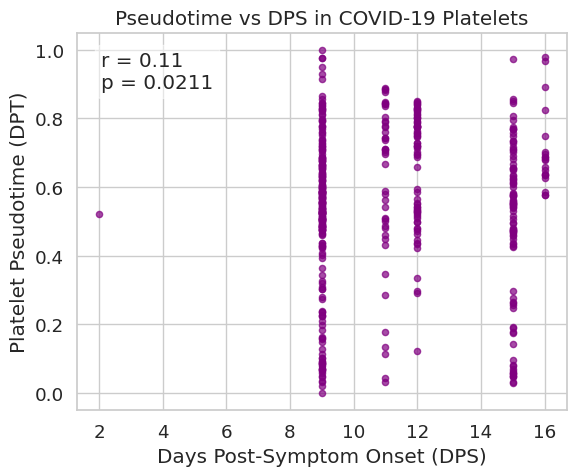

Ventilated status sample sizes: {'NonVent': 243, 'Vent': 221}


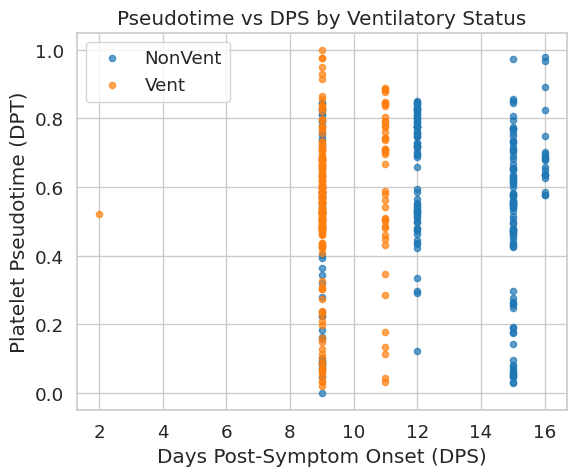

In [6]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Subset COVID-19 platelets using coarse cell type and disease status; ensures clarity by copying the subset
covid_platelets = adata[adata.obs['cell_type_coarse'] == 'Platelet'].copy()
covid_platelets = covid_platelets[covid_platelets.obs['Status'] == 'COVID'].copy()

# Normalize total counts per cell and log-transform
sc.pp.normalize_total(covid_platelets, target_sum=1e4)
sc.pp.log1p(covid_platelets)

# Define pro-thrombotic marker genes and check for their availability
marker_genes = ['PF4', 'ITGA2B', 'SELP', 'PPBP']
available_markers = [g for g in marker_genes if g in covid_platelets.var_names]
if len(available_markers) == 0:
    raise ValueError('None of the pro-thrombotic marker genes found in COVID platelet dataset.')

# Compute highly variable genes without subsetting the object
sc.pp.highly_variable_genes(covid_platelets, n_top_genes=100, flavor='seurat', subset=False, batch_key='Status')
hvgs = covid_platelets.var_names[covid_platelets.var['highly_variable']].tolist()

# Take the union of the available marker genes with the HVGs
selected_genes = list(set(available_markers).union(set(hvgs)))

# Subset the anndata object to only include the selected gene set
covid_platelets = covid_platelets[:, selected_genes].copy()

# Compute PCA for dimensionality reduction
sc.tl.pca(covid_platelets, svd_solver='arpack')

# Construct the neighborhood graph using the top principal components
sc.pp.neighbors(covid_platelets, n_neighbors=15, n_pcs=20)

# Calculate the diffusion map to capture continuous cellular transitions
sc.tl.diffmap(covid_platelets)

# Set a root cell for Diffusion Pseudotime calculation
covid_platelets.uns['iroot'] = 0

# Compute diffusion pseudotime (DPT) using a default or specified number of diffusion components
sc.tl.dpt(covid_platelets, n_dcs=10)

# Extract pseudotime values from the computed DPT
pseudotime = covid_platelets.obs['dpt_pseudotime']

# Ensure DPS metadata is available and is numeric
if 'DPS' not in covid_platelets.obs.columns:
    raise ValueError('DPS metadata not found in the dataset.')

dps = pd.to_numeric(covid_platelets.obs['DPS'], errors='coerce')

# Filter out cells with missing DPS data
valid = ~dps.isna()
pt_valid = pseudotime[valid]
dps_valid = dps[valid]

# Calculate Spearman correlation between pseudotime and DPS and print the results
corr_coef, p_val = spearmanr(pt_valid, dps_valid)
print(f"Spearman correlation between pseudotime and DPS: r = {corr_coef:.3f}, p-value = {p_val:.3g}")

# Visualize pseudotime versus DPS with scatter plot and annotation of correlation statistics
plt.figure(figsize=(6,5))
plt.scatter(dps_valid, pt_valid, color='purple', alpha=0.7, s=20)
plt.xlabel('Days Post-Symptom Onset (DPS)')
plt.ylabel('Platelet Pseudotime (DPT)')
plt.title('Pseudotime vs DPS in COVID-19 Platelets')
plt.text(0.05, 0.95, f'r = {corr_coef:.2f}\np = {p_val:.3g}', transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.tight_layout()
plt.show()

# If ventilatory status metadata is available, stratify the scatter plot accordingly
if 'Ventilated' in covid_platelets.obs.columns:
    vent_counts = covid_platelets.obs['Ventilated'].value_counts().to_dict()
    print('Ventilated status sample sizes:', vent_counts)
    
    plt.figure(figsize=(6,5))
    statuses = covid_platelets.obs['Ventilated'].unique()
    for status in statuses:
        mask = (covid_platelets.obs['Ventilated'] == status) & valid
        plt.scatter(dps[mask], pseudotime[mask], label=status, alpha=0.7, s=20)
    plt.xlabel('Days Post-Symptom Onset (DPS)')
    plt.ylabel('Platelet Pseudotime (DPT)')
    plt.title('Pseudotime vs DPS by Ventilatory Status')
    plt.legend()
    plt.tight_layout()
    plt.show()